In [2]:
!pip install scikit-surprise # install the missing package
!pip install dash
!pip install pandas

In [20]:
import dash
import pandas as pd 
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
from sklearn.decomposition import TruncatedSVD
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import numpy as np
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split
from surprise import Dataset



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/suporte/1234/venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/suporte/1234/venv/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/suporte/1234/venv/lib/python3

ImportError: numpy.core.multiarray failed to import (auto-generated because you didn't call 'numpy.import_array()' after cimporting numpy; use '<void>numpy._import_array' to disable if you are certain you don't need it).

In [21]:
ratings = pd.read_csv('/home/suporte/1234/ratings.csv')  # Assumindo um arquivo ratings.csv com colunas userId, movieId e rating
movies = pd.read_csv('/home/suporte/1234/movies.csv')    # Assumindo um arquivo movies.csv com colunas movieId e title



In [22]:

ratings = ratings.drop_duplicates()
ratings['userId'] = ratings['userId'].astype(int)
ratings['movieId'] = ratings['movieId'].astype(int)
ratings['rating'] = ratings['rating'].astype(float)

# Cortando 30% dos dados (mantendo 70%)
ratings_sample = ratings.sample(frac=0.7, random_state=42)

# Tratamento de dados para movies
movies = movies.drop_duplicates()
movies['movieId'] = movies['movieId'].astype(int)
movies['title'] = movies['title'].astype(str)

# Cortando 30% dos dados (mantendo 70%)
movies_sample = movies.sample(frac=0.7, random_state=42)

# Confirmar alterações
print("Tamanho original de ratings:", ratings.shape)
print("Tamanho reduzido de ratings:", ratings_sample.shape)

print("\nTamanho original de movies:", movies.shape)
print("Tamanho reduzido de movies:", movies_sample.shape)

Tamanho original de ratings: (32000204, 4)
Tamanho reduzido de ratings: (22400143, 4)

Tamanho original de movies: (87585, 3)
Tamanho reduzido de movies: (61309, 3)


In [23]:
# Amostragem de uma fração pequena de usuários e filmes
unique_users = ratings['userId'].drop_duplicates().sample(n=100, random_state=42)  # Limitando a 100 usuários
unique_movies = ratings['movieId'].drop_duplicates().sample(n=100, random_state=42)  # Limitando a 100 filmes

# Filtrando ratings por esses usuários e filmes amostrados
ratings_sample = ratings[ratings['userId'].isin(unique_users) & ratings['movieId'].isin(unique_movies)]

# Criando a matriz de usuários e filmes
ratings_matrix = ratings_sample.pivot(index='userId', columns='movieId', values='rating').fillna(0)

# Aplicando SVD com 1 componente
svd = TruncatedSVD(n_components=1, random_state=42)
matrix_svd = svd.fit_transform(ratings_matrix)

# Exibindo informações da matriz SVD
print("Forma da matriz SVD:", matrix_svd.shape)


Forma da matriz SVD: (20, 1)


In [24]:
from sklearn.decomposition import NMF

# Aplicando NMF com 1 componente
nmf = NMF(n_components=1, random_state=42)
matrix_nmf = nmf.fit_transform(ratings_matrix)

# Exibindo informações da matriz NMF
print("Forma da matriz NMF:", matrix_nmf.shape)


Forma da matriz NMF: (20, 1)


/home/suporte/1234/venv/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [25]:
from sklearn.neighbors import NearestNeighbors

# Treinando um modelo KNN
knn = NearestNeighbors(n_neighbors=5, algorithm='auto', metric='cosine').fit(ratings_matrix)

# Encontrando os 5 vizinhos mais próximos de um usuário
distances, indices = knn.kneighbors([ratings_matrix.iloc[0]], n_neighbors=5)

# Exibindo os índices dos vizinhos
print("Índices dos vizinhos mais próximos:", indices)


Índices dos vizinhos mais próximos: [[14 15 13  8 17]]


In [26]:
# Supondo que você já tenha o dataframe `movies` carregado
# Exemplo: movies = pd.read_csv('movies.csv')

# Mesclando 'ratings' com 'movies' para obter o nome dos filmes
ratings_with_titles = ratings.merge(movies[['movieId', 'title']], on='movieId')

# Calculando a média dos ratings por filme (agrupando pelo nome do filme)
average_ratings = ratings_with_titles.groupby('title')['rating'].mean()

# Selecionando os 10 filmes com as maiores médias de rating
top_movies = average_ratings.nlargest(10).reset_index()

# Melhorando a saída do print (sem índice)
print("Top 10 filmes com as maiores médias de rating:\n")
print("{:<50} {:<10}".format("Filme", "Média de Rating"))
print("="*60)
for _, row in top_movies.iterrows():  # O _ ignora o índice
    print("{:<50} {:.2f}".format(row['title'], row['rating']))


Top 10 filmes com as maiores médias de rating:

Filme                                              Média de Rating
$uperthief: Inside America's Biggest Bank Score (2012) 5.00
'Tis the Season to be Merry (2021)                 5.00
1 Message (2011)                                   5.00
11 September Vragen (2016)                         5.00
12 Dog Days Till Christmas (2014)                  5.00
1500 Steps (2014)                                  5.00
1964: Brazil Between Weapons and Books (2019)      5.00
1984 Revolution (2011)                             5.00
2 (2007)                                           5.00
2 Years of Love (2016)                             5.00


In [27]:
# Mesclando 'ratings' com 'movies' para obter os nomes dos filmes
ratings_with_titles = ratings.merge(movies[['movieId', 'title']], on='movieId')

# Contando o número de ratings por filme
popularity = ratings_with_titles.groupby('title')['rating'].count()

# Ordenando por popularidade (número de ratings) e exibindo os 10 mais populares
top_popular_movies = popularity.nlargest(10)
print("Top 10 filmes mais populares:")
for title, count in top_popular_movies.items():
    print(f"{title}: {count} ratings")

Top 10 filmes mais populares:
Shawshank Redemption, The (1994): 102929 ratings
Forrest Gump (1994): 100296 ratings
Pulp Fiction (1994): 98409 ratings
Matrix, The (1999): 93808 ratings
Silence of the Lambs, The (1991): 90330 ratings
Star Wars: Episode IV - A New Hope (1977): 85010 ratings
Fight Club (1999): 77332 ratings
Jurassic Park (1993): 75233 ratings
Schindler's List (1993): 73849 ratings
Lord of the Rings: The Fellowship of the Ring, The (2001): 73122 ratings


Forma da matriz SVD: (87585, 2)


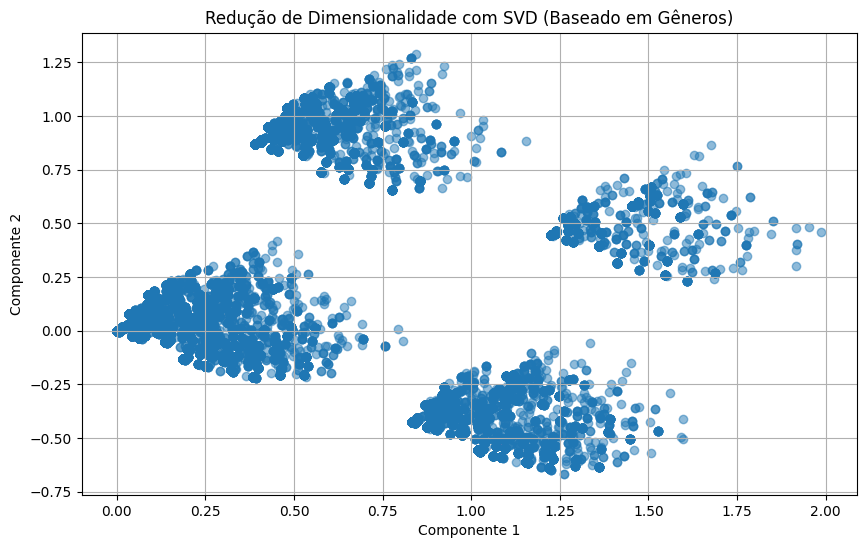


Recomendações baseadas nos gêneros de 'Pulp Fiction':
- Under Construction (2003) (Gêneros: Comedy|Crime|Drama|Thriller)
- Dear Mr. Gacy (2010) (Gêneros: Comedy|Crime|Drama|Horror|Thriller)
- Bad Boys (1995) (Gêneros: Action|Comedy|Crime|Drama|Thriller)
- Godspeed (2016) (Gêneros: Comedy|Crime|Drama|Thriller)
- Don (1978) (Gêneros: Action|Comedy|Crime|Drama|Musical|Thriller)
- Leaves of Grass (2009) (Gêneros: Comedy|Crime|Drama|Thriller)
- Body Count (1998) (Gêneros: Comedy|Crime|Drama|Thriller)
- The 39 Steps (1959) (Gêneros: Action|Adventure|Comedy|Crime|Drama|Thriller)
- Freeway II: Confessions of a Trickbaby (1999) (Gêneros: Comedy|Crime|Drama|Thriller)
- Tiger's Tail, The (2006) (Gêneros: Comedy|Crime|Drama|Mystery|Thriller)
- Pulp Fiction (1994) (Gêneros: Comedy|Crime|Drama|Thriller)
- Ichi the Killer (Koroshiya 1) (2001) (Gêneros: Action|Comedy|Crime|Drama|Horror|Thriller)
- Suicide Kings (1997) (Gêneros: Comedy|Crime|Drama|Mystery|Thriller)
- Hard Word, The (2002) (Gêneros: Co

In [32]:
# Amostrando 5.000 filmes aleatoriamente
movies_sample = movies.sample(n=len(movies[::]), random_state=42)

# Extraindo os gêneros e criando colunas binárias para cada gênero
genres_matrix = movies_sample['genres'].str.get_dummies(sep='|')

# Criando uma matriz de filmes e gêneros
movies_genre_matrix = pd.concat([movies_sample[['movieId']], genres_matrix], axis=1).set_index('movieId')

# Aplicando SVD com 2 componentes
svd = TruncatedSVD(n_components=2, random_state=42)
matrix_svd = svd.fit_transform(movies_genre_matrix)

# Convertendo para DataFrame para fácil manipulação
svd_df = pd.DataFrame(matrix_svd, index=movies_genre_matrix.index, columns=[f'Component {i+1}' for i in range(2)])

# Exibindo a forma da matriz SVD
print("Forma da matriz SVD:", svd_df.shape)

# Visualizando a redução de dimensionalidade
plt.figure(figsize=(10, 6))
plt.scatter(svd_df['Component 1'], svd_df['Component 2'], alpha=0.5)
plt.title('Redução de Dimensionalidade com SVD (Baseado em Gêneros)')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.grid(True)
plt.show()


# Função para recomendar filmes
def recommend_movies_by_genre(movie_title, n_recommendations=5):
    # Obter o gênero do filme escolhido
    chosen_movie_genres = movies[movies['title'].str.contains(movie_title, case=False, na=False)]['genres'].values
    if len(chosen_movie_genres) == 0:
        print(f"Erro: O filme '{movie_title}' não foi encontrado.")
        return pd.Series([])

    chosen_movie_genres = chosen_movie_genres[0].split('|')  # Quebrar os gêneros em uma lista
    
    # Função auxiliar para contar gêneros em comum
    def genre_similarity(genres):
        movie_genres = genres.split('|')
        return len(set(movie_genres).intersection(set(chosen_movie_genres)))
    
    # Adicionar uma nova coluna para contar quantos gêneros em comum os filmes têm com o escolhido
    movies['similarity_score'] = movies['genres'].apply(genre_similarity)
    
    # Ordenar os filmes pela pontuação de similaridade e filtrar o filme escolhido
    recommended_movies = movies[movies['title'] != movie_title].sort_values(by='similarity_score', ascending=False)

    # Retornar os filmes mais similares
    return recommended_movies[['title', 'genres']].head(n_recommendations)

# Exemplo de recomendação
chosen_movie = "Pulp Fiction"  # Exemplo de filme
recommended = recommend_movies_by_genre(chosen_movie, n_recommendations=100)

# Exibindo as recomendações
print(f"\nRecomendações baseadas nos gêneros de '{chosen_movie}':")
for idx, row in recommended.iterrows():
    print(f"- {row['title']} (Gêneros: {row['genres']})")